In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle, json, re, time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook as tqdm
#from tqdm import tqdm
from tqdm import trange

from gensim.parsing import remove_stopwords

import os

CWD = os.getcwd()
#if 'task1' not in CWD:
   # CWD = os.path.join(CWD, 'task1')


### Hyperparameter logging and tuning
For tuning best models, you may need to save the used hyperparameters.<br />
The two cells below make the logging convenient.

In [2]:
### Helper function for hyperparameters logging
import configparser

def write_config(filename, with_time=False):
    config = configparser.ConfigParser()
    config['DEFAULT'] = {'embedding_dim': embedding_dim,
                         'hidden_dim': hidden_dim,
                         'learning_rate': learning_rate,
                         'max_epoch': max_epoch,
                         'batch_size': batch_size}
    
    if with_time == False:
        with open("{}.ini".format(filename), 'w') as configfile:
            config.write(configfile)
        return 'config'            
    else:
        timestr = time.strftime("%Y%m%d_%H%M%S")
        filename = filename + '_' + timestr
        with open("{}.ini".format(filename), 'w') as configfile:
            config.write(configfile)
        return ( 'config' + timestr )

In [3]:
### Hyperparameters tuning
### Run this cell for renewing the hyperparameters

embedding_dim = 300
hidden_dim = 512
learning_rate = 1e-4
max_epoch = 10
batch_size = 16

# write the hyperparameters into config.ini
#write_config(os.path.join(CWD,"config"))

# if you are lazy to rename the config file then uncomment the below line
config_fname = write_config(os.path.join(CWD,"config"), True)
# config_fname will be used when logging training scalar to tensorboard

### Collect words from baseline preprocessing

In [4]:
def CleanData(sent):
    '''
    Try to remove website link, and use [NUM] to replace numbers
    '''
    sent = re.sub(r'([--:\w?@%&+~#=]*\.[a-z]{2,4}\/{0,2})((?:[?&](?:\w+)=(?:\w+))+|[--:\w?@%&+~#=]+)?', '', sent)
    sent = re.sub(r'[0-9]+\.[0-9]+', '1', sent)
    #sent = re.sub(r'[0-9]+\.[0-9]+', ' [NUM] ', sent)
    return sent

from multiprocessing import Pool
from nltk.tokenize import word_tokenize

def collect_words(data_path, n_workers=4):
    df = pd.read_csv(data_path, dtype=str)
    df['Abstract'] = df['Abstract'].apply(func = CleanData)
    # create a list for storing sentences
    sent_list = []
    for i in df.iterrows():
        sent_list += i[1]['Abstract'].split('$$$')

    chunks = [
        ' '.join(sent_list[i:i + len(sent_list) // n_workers])
        for i in range(0, len(sent_list), len(sent_list) // n_workers)
    ]
    with Pool(n_workers) as pool:
        # word_tokenize for word-word separation
        chunks = pool.map_async(word_tokenize, chunks)
        words = set(sum(chunks.get(), []))

    return words

In [5]:
words = set()
words |= collect_words(os.path.join(CWD,'data/trainset.csv'))

In [6]:
PAD_TOKEN = 0
UNK_TOKEN = 1
word_dict = {'<pad>':PAD_TOKEN,'<unk>':UNK_TOKEN}
for word in words:
    word_dict[word]=len(word_dict)

### Download Glove pretrained word embedding from web.

Link: http://nlp.stanford.edu/data/glove.6B.zip <br />
It takes about 5 minutes for the download.


### Parsing the GloVe word-embeddings file

Parse the unzipped file (a .txt file) to build an index that maps words (as strings) to their vector representation (as number vectors)

In [7]:
### Parsing the GloVe word-embeddings file
# Parse the unzipped file (a .txt file) to build an index that maps words (as strings) to their vector representation (as number vectors)

wordvector_path = 'glove/glove.6B.300d.txt'
embeddings_index = {}
f = open(wordvector_path)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [8]:
### Preparing the GloVe word-embeddings matrix

max_words = len(word_dict)
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_dict.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [9]:
embedding_matrix = torch.FloatTensor(embedding_matrix)

### Data Formatting
建立完字典後，我們要將 data 切成數個 batch，並且將輸入的句子轉成數字，將答案轉成 onehot vector。
- `label_to_onehot(labels)`:  
    將 datasert 中的 label string 轉成 onehot encoding vector。  
- `sentence_to_indices(sentence, word_dict)`:  
    將輸入的句子中每個 word 轉成字典中對應的 index  
    ex : 'i love ncku' -> $[1,2,3]$
- `get_dataset(data_path, word_dict, n_workers=4)`:  
    將 dataset 讀入
- `preprocess_samples(dataset, word_dict)`:  
    傳入所有 input sentences 並進行 data preprocessing  
- `preprocess_sample(data, word_dict)`:  
    主要透過這個 function 移除存在於 'Abstract' 中的 `$` 符號  
    並將 'Label' 轉成 onehot encoding vector。

In [10]:
def label_to_onehot(labels):
    """ Convert label to onehot .
        Args:
            labels (string): sentence's labels.
        Return:
            outputs (onehot list): sentence's onehot label.
    """
    label_dict = {'BACKGROUND': 0, 'OBJECTIVES':1, 'METHODS':2, 'RESULTS':3, 'CONCLUSIONS':4, 'OTHERS':5}
    onehot = [0,0,0,0,0,0]
    for l in labels.split('/'):
        onehot[label_dict[l]] = 1
    return onehot
        
def sentence_to_indices(sentence, word_dict):
    """ Convert sentence to its word indices.
    Args:
        sentence (str): One string.
    Return:
        indices (list of int): List of word indices.
    """
    return [word_dict.get(word,UNK_TOKEN) for word in word_tokenize(sentence)]
    
def get_dataset(data_path, word_dict, n_workers=4):
    """ Load data and return dataset for training and validating.

    Args:
        data_path (str): Path to the data.
    """
    dataset = pd.read_csv(data_path, dtype=str)

    results = [None] * n_workers
    with Pool(processes=n_workers) as pool:
        for i in range(n_workers):
            batch_start = (len(dataset) // n_workers) * i
            if i == n_workers - 1:
                batch_end = len(dataset)
            else:
                batch_end = (len(dataset) // n_workers) * (i + 1)
            
            batch = dataset[batch_start: batch_end]
            results[i] = pool.apply_async(preprocess_samples, args=(batch,word_dict))

        pool.close()
        pool.join()

    processed = []
    for result in results:
        processed += result.get()
    return processed

def preprocess_samples(dataset, word_dict):
    """ Worker function.

    Args:
        dataset (list of dict)
    Returns:
        list of processed dict.
    """
    processed = []
    for sample in tqdm(dataset.iterrows(), total=len(dataset)):
        processed.append(preprocess_sample(sample[1], word_dict))

    return processed

def preprocess_sample(data, word_dict):
    """
    Args:
        data (dict)
    Returns:
        dict
    """
    ## clean abstracts by removing $$$
    processed = {}
    processed['Abstract'] = [sentence_to_indices(sent, word_dict) for sent in data['Abstract'].split('$$$')]
    
    ## convert the labels into one-hot encoding
    if 'Task 1' in data:
        processed['Label'] = [label_to_onehot(label) for label in data['Task 1'].split(' ')]
        
    return processed

In [11]:
print('[INFO] Start processing trainset...')
train = get_dataset(os.path.join(CWD,'data/trainset.csv'), word_dict, n_workers=4)
print('[INFO] Start processing validset...')
valid = get_dataset(os.path.join(CWD,'data/validset.csv'), word_dict, n_workers=4)
print('[INFO] Start processing testset...')
test = get_dataset(os.path.join(CWD,'data/testset.csv'), word_dict, n_workers=4)

[INFO] Start processing trainset...




[INFO] Start processing validset...




[INFO] Start processing testset...






### Create a dataset class for the abstract dataset
`torch.utils.data.Dataset` is an abstract class representing a dataset.<br />Your custom dataset should inherit Dataset and override the following methods:

- `__len__` so that len(dataset) returns the size of the dataset.
- `__getitem__` to support the indexing such that dataset[i] can be used to get i
th sample
- `collate_fn` Users may use customized collate_fn to achieve custom batching
    - Here we pad sequences of various lengths (make same length of every single sentence)

In [12]:
class AbstractDataset(Dataset):
    def __init__(self, data, pad_idx, max_len = 64):
        self.data = data
        self.pad_idx = pad_idx
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
        
    def collate_fn(self, datas):
        # get max length in this batch
        max_sent = max([len(data['Abstract']) for data in datas])
        max_len = max([min(len(sentence), self.max_len) for data in datas for sentence in data['Abstract']])
        batch_abstract = []
        batch_label = []
        sent_len = []
        for data in datas:
            # padding abstract to make them in same length
            pad_abstract = []
            for sentence in data['Abstract']:
                if len(sentence) > max_len:
                    pad_abstract.append(sentence[:max_len])
                else:
                    pad_abstract.append(sentence+[self.pad_idx]*(max_len-len(sentence)))
            sent_len.append(len(pad_abstract))
            pad_abstract.extend([[self.pad_idx]*max_len]*(max_sent-len(pad_abstract)))
            batch_abstract.append(pad_abstract)
            # gather labels
            if 'Label' in data:
                pad_label = data['Label']
                pad_label.extend([[0]*6]*(max_sent-len(pad_label)))
                
                batch_label.append(pad_label)
        return torch.LongTensor(batch_abstract), torch.FloatTensor(batch_label), sent_len

In [13]:
trainData = AbstractDataset(train, PAD_TOKEN, max_len = 64)
validData = AbstractDataset(valid, PAD_TOKEN, max_len = 64)
testData = AbstractDataset(test, PAD_TOKEN, max_len = 64)

In [14]:
class Net(nn.Module):
    def __init__(self, vocabulary_size):
        super(Net, self).__init__()
        self.embedding_size = embedding_dim
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocabulary_size, self.embedding_size)
        self.embedding.weight = torch.nn.Parameter(embedding_matrix)
        self.sent_rnn = nn.GRU(self.embedding_size,
                                self.hidden_dim,
                                bidirectional=True,
                                batch_first=True)
        ## multi-GRU
        self.multi_rnn = nn.GRU(self.hidden_dim*2,
                                self.hidden_dim,
                                bidirectional=True,
                                batch_first=True)
        
        self.l1 = nn.Linear(self.hidden_dim*2, self.hidden_dim)
        torch.nn.init.xavier_normal_(self.l1.weight)
        #self.layernorm1 = nn.LayerNorm(self.hidden_dim*2)
        #self.layernorm2 = nn.LayerNorm(self.hidden_dim)
        self.l2 = nn.Linear(self.hidden_dim, 6)

    # b: batch_size
    # s: number of sentences
    # w: number of words
    # e: embedding_dim
    def forward(self, x):
        x = self.embedding(x)
        b,s,w,e = x.shape
        x = x.view(b,s*w,e)
        x, __ = self.sent_rnn(x)
        #x = x.view(b,s,w,-1)
        #x = torch.max(x,dim=2)[0]
        
        ## multi bi-GRU 
        ############################句子不夠深->應該不用這麼深？==>每層的max ht都comcat起來
        x = x.view(b,s*w,-1)
        x, __ = self.multi_rnn(x)
        x = x.view(b,s,w,-1)
        x = torch.max(x,dim=2)[0]
        
        x = torch.relu(self.l1(x))
        
        #x = self.layernorm2(x)
        
        x = torch.sigmoid(self.l2(x))
        return x

In [15]:
### Helper functions for scoring

class F1():
    def __init__(self):
        self.threshold = 0.5
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0
        self.name = 'F1'

    def reset(self):
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0

    def update(self, predicts, groundTruth):
        predicts = predicts > self.threshold
        self.n_precision += torch.sum(predicts).data.item()
        self.n_recall += torch.sum(groundTruth).data.item()
        self.n_corrects += torch.sum(groundTruth.type(torch.bool) * predicts).data.item()

    def get_score(self):
        recall = self.n_corrects / self.n_recall
        precision = self.n_corrects / (self.n_precision + 1e-20)
        return 2 * (recall * precision) / (recall + precision + 1e-20)

    def print_score(self):
        score = self.get_score()
        return '{:.5f}'.format(score)

In [16]:
def _run_epoch(epoch, mode):
    model.train(True)
    if mode=="train":
        description = 'Train'
        dataset = trainData
        shuffle = True
    else:
        description = 'Valid'
        dataset = validData
        shuffle = False
    dataloader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            collate_fn=dataset.collate_fn,
                            num_workers=8)

    trange = tqdm(enumerate(dataloader), total=len(dataloader), desc=description)
    loss = 0
    f1_score = F1()
    for i, (x, y, sent_len) in trange:
        o_labels, batch_loss = _run_iter(x,y)
        if mode=="train":
            opt.zero_grad()
            batch_loss.backward()
            opt.step()

        loss += batch_loss.item()
        f1_score.update(o_labels.cpu(), y)

        trange.set_postfix(
            loss=loss / (i + 1), f1=f1_score.print_score())
    
    if mode=="train":
        history['train'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})
        writer.add_scalar('Loss/train', loss/ len(trange), epoch)
        writer.add_scalar('F1_score/train', f1_score.get_score(), epoch)
    else:
        history['valid'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})
        writer.add_scalar('Loss/valid', loss/ len(trange), epoch)
        writer.add_scalar('F1_score/valid', f1_score.get_score(), epoch)
    trange.close()
    

def _run_iter(x,y):
    abstract = x.to(device)
    labels = y.to(device)
    o_labels = model(abstract)
    l_loss = criteria(o_labels, labels)
    return o_labels, l_loss

def save(epoch):
    if not os.path.exists(os.path.join(CWD,'model')):
        os.makedirs(os.path.join(CWD,'model'))
    torch.save(model.state_dict(), os.path.join( CWD,'model/multi_biGRU_model.pkl.'+str(epoch) ))
    with open( os.path.join( CWD,'model/multi_biGRU_history.json'), 'w') as f:
        json.dump(history, f, indent=4)

Epoch: 0



Epoch: 1



Epoch: 2



Epoch: 3



Epoch: 4



Epoch: 5



Epoch: 6



Epoch: 7



Epoch: 8



Epoch: 9


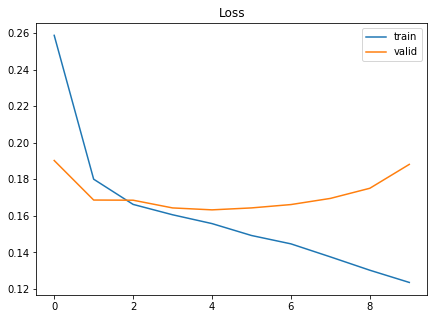

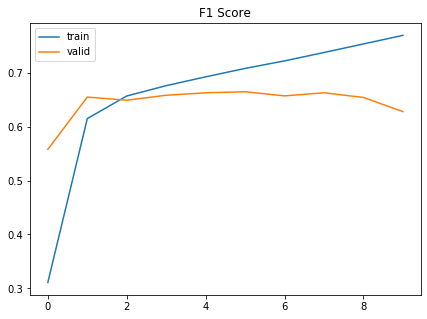

Best F1 score  0.6644996059889677  ,epoch: 5


In [17]:
model = Net(len(word_dict))

opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criteria = torch.nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)
with torch.no_grad():
        model.to(device)
history = {'train':[],'valid':[]}

## Tensorboard
## save path: test_experiment/
tf_path = os.path.join(CWD, 'test_experiment')
if not os.path.exists(tf_path):
    os.mkdir(tf_path)
writer = SummaryWriter(os.path.join(tf_path,config_fname))

for epoch in range(max_epoch):
    print('Epoch: {}'.format(epoch))
    _run_epoch(epoch, 'train')
    _run_epoch(epoch, 'valid')
    save(epoch)

# Plot the training results 
with open(os.path.join(CWD,'model/multi_biGRU_history.json'), 'r') as f:
    history = json.loads(f.read())
    
train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_f1 = [l['f1'] for l in history['train']]
valid_f1 = [l['f1'] for l in history['valid']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('F1 Score')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.legend()
plt.show()

score,epoch=max([[l['f1'], idx] for idx, l in enumerate(history['valid'])])
print('Best F1 score ', score,' ,epoch:',epoch)
## overfitting!!

In [20]:
# This is the Prediction cell.

# fill the epoch of the lowest val_loss to best_model
best_model = 9
model.load_state_dict(state_dict=torch.load(os.path.join(CWD,'model/multi_biGRU_model.pkl.{}'.format(best_model))))
model.train(False)
# double ckeck the best_model_score
_run_epoch(1, 'valid')

#### start testing
#dataloader = DataLoader(dataset=testData,
 #                           batch_size=64,
  #                          shuffle=False,
   #                         collate_fn=testData.collate_fn,
    #                        num_workers=8)
#trange = tqdm(enumerate(dataloader), total=len(dataloader), desc='Predict')
#prediction = []
#for i, (x, y, sent_len) in trange:
 #   o_labels = model(x.to(device))
  #  o_labels = o_labels>0.5
   # for idx, o_label in enumerate(o_labels):
    #    prediction.append(o_label[:sent_len[idx]].to('cpu'))
#prediction = torch.cat(prediction).detach().numpy().astype(int)

### 釋放GPU memory

In [21]:
torch.cuda.empty_cache()
del trainData,embedding_matrix,validData ,testData

In [ ]:
### Helper function for creating a csv file following the submission format

def SubmitGenerator(prediction, sampleFile, public=True, filename='prediction.csv'):
    sample = pd.read_csv(sampleFile)
    submit = {}
    submit['order_id'] = list(sample.order_id.values)
    redundant = len(sample) - prediction.shape[0]
    if public:
        submit['BACKGROUND'] = list(prediction[:,0]) + [0]*redundant
        submit['OBJECTIVES'] = list(prediction[:,1]) + [0]*redundant
        submit['METHODS'] = list(prediction[:,2]) + [0]*redundant
        submit['RESULTS'] = list(prediction[:,3]) + [0]*redundant
        submit['CONCLUSIONS'] = list(prediction[:,4]) + [0]*redundant
        submit['OTHERS'] = list(prediction[:,5]) + [0]*redundant
    else:
        submit['BACKGROUND'] = [0]*redundant + list(prediction[:,0])
        submit['OBJECTIVES'] = [0]*redundant + list(prediction[:,1])
        submit['METHODS'] = [0]*redundant + list(prediction[:,2])
        submit['RESULTS'] = [0]*redundant + list(prediction[:,3])
        submit['CONCLUSIONS'] = [0]*redundant + list(prediction[:,4])
        submit['OTHERS'] = [0]*redundant + list(prediction[:,5])
    df = pd.DataFrame.from_dict(submit) 
    df.to_csv(filename,index=False)

In [ ]:
### Output csv for submission

SubmitGenerator(prediction,
                os.path.join(CWD,'data/task1_sample_submission.csv'), 
                True, 
                os.path.join(CWD,'submission_1106.csv'))

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=task1/test_experiment